In [20]:
%load_ext autoreload
%autoreload 

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

import shared.query as q
import shared.viz as viz

from scipy import sparse
from sklearn.metrics import pairwise_distances

viz.set_style()
conn = q.connect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Recommendations

This worksheet explores the inner workings of Presto! - transforming reviews into recommendations

In [4]:
## Settings

max_product_pool_size = 10
max_user_pool_size = 20
fill_value = 0
category = 'Music'
title = 'The Pleasure Principle'

product_name_limit = max(len(title), 20)

In [5]:
product = q.find_products(category, search_term = title, conn = conn, exact_match = True).loc[0]
product

find_products: 8 results in 0.004 seconds


id                                                     B000006NTW
reviews                                                        80
title                                      The Pleasure Principle
creator                                                Gary Numan
publisher                                                        
description     Digitally remastered! Debut 1979 solo album, r...
release_date                                       April 30, 2006
category                                                    Music
subcategory                                                      
Name: 0, dtype: object

## Get Related Reviews

Get books that have reviewers in common with this book:

In [7]:
reviews = q.get_reviews(product.id, conn)
related_reviews = q.get_related_reviews(reviews, conn, filter_unhelpful_reviews = True, max_reviewer_count = max_user_pool_size, max_product_count = max_product_pool_size)
related_reviews[:2]

get_reviews: 80 results in 0.024 seconds
0.032: Got 3531 related reviews of 3274 products by 80 users
0.0343: Filtered 51 related reviews by user and/or product


,user_id,product_id,rating,upvotes,downvotes
55,AECFQOZKAJ7O2HGAEFPU74YAP5HQ,B000002GYI,5,4,0
56,AECFQOZKAJ7O2HGAEFPU74YAP5HQ,B000002GZ4,3,4,0


## Compute Cosine Similarities

### Create Rating Table of products by reviewers

In [10]:
user_ratings_per_product = pd.pivot(
    related_reviews,
    values = 'rating',
    index = 'product_id',
    columns = 'user_id'
)
user_ratings_per_product.fillna('')

user_id,AECFQOZKAJ7O2HGAEFPU74YAP5HQ,AF4NADS7QTIYHSQZQ33MBMEPYYXQ,AF75VSMGAX4XPYZVWIVPZI4JIIIQ,AFAWQJAG45W2BOQFTYWI3HOTMRWQ,AFDPKO7LALFIGDQ3JTUMMIB6O4PA,AFSHTYBUE763W7XYWLD3AIQ73ZLA,AFVTL45JTUQTHK56IYHHVUXFKFQQ,AFYHLKGGAQDHNGM5H4ML43WU36KQ,AGAKV2IAD5E3UE336W2LNQDLAV4Q,AGD4XT4QXBSLMXLMK5XMPERX6RZA,AGDL3UCOMT5XSUUKG3LTAMWJYBAQ,AGENBTR33AZRFFTATRZ6QMOBDV5A,AGFJGSV3ZT55GYTTP5I5SUUJWM7Q,AGQ7A3WCFBUPHUDCBRXOULQSUI7Q,AGYCVIK3SVOSMQUAVYHKPWG73MAA,AH3F4AYI762FO274ARPOOMBXOCLA,AHJ3S3V3XBCJZFF7EE4RALKBJPPQ,AHRMC6WMY67TRGUW63SJPJ56ZPVQ,AHTP2JRBBJ3LAUJYIAB7N2KBLB4A,AHX4K33AYWI6MDQ7ZPUL3W5NKVMA
product_id,,,,,,,,,,,,,,,,,,,,
B0000004U8,,,,,,,,,3.0,,,,,4.0,,,5.0,,,
B000002GYI,5.0,,,,,,,,5.0,,,,,,,,5.0,,,
B000002GZ4,3.0,,3.0,,,,,,,,,5.0,,,,,4.0,,,
B000002KNM,4.0,,4.0,,,,,,2.0,,,,,,,,,,,
B000006NTP,,4.0,,3.0,,,,,5.0,,,,,5.0,,,,,5.0,
B000006NTW,4.0,5.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0
B0000085CU,,,5.0,,,,,,,,,5.0,,,,,,,5.0,
B00000GAIW,,,,,,5.0,,,5.0,,,,,,,,5.0,,,
B00000I2B0,,5.0,,,,,,,,,,,,5.0,,,5.0,,5.0,


product details 10: 10 results in 0.002 seconds


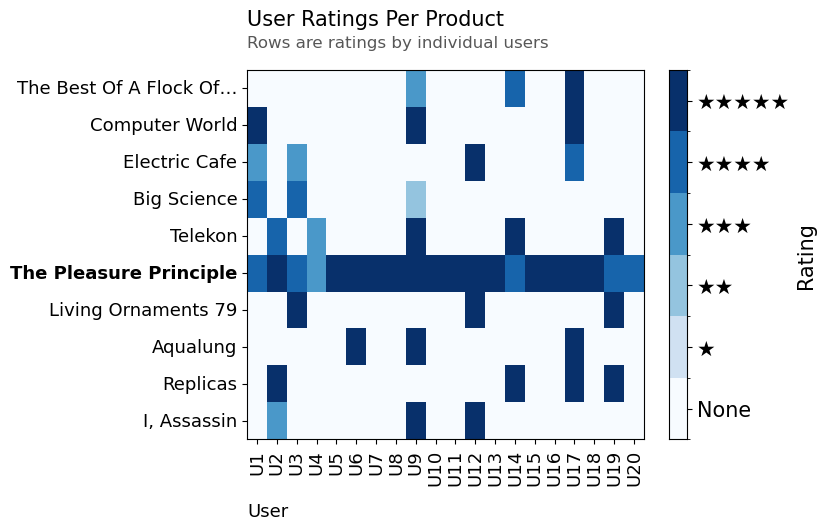

In [11]:

import matplotlib as mpl

user_ratings_per_product.fillna(fill_value, inplace = True)
product_ids = user_ratings_per_product.index.values
product_names = q.get_product_details(product_ids, conn, select = 'title')['title']

user_ratings_per_product.index = product_names
viz.plot_user_ratings_by_product(user_ratings_per_product, product.title, conn, product_name_limit = product_name_limit)
plt.gcf().savefig('../images/recommendation-ratings.png', bbox_inches = 'tight')

### Create Pairwise Similarity table

For each pair of products/rows in the above rating map, find the similarity between the two rows. Output the pairwise similarities in a matrix:

In [13]:
user_ratings_per_product_sparse = sparse.csr_matrix(user_ratings_per_product.fillna(fill_value))
pairwise_cosine_similarities = pairwise_distances(user_ratings_per_product_sparse, metric = 'cosine')
pairwise_cosine_similarities = pd.DataFrame(pairwise_cosine_similarities, index = product_names, columns = product_names)
pairwise_cosine_similarities

title,The Best Of A Flock Of Seagulls,Computer World,Electric Cafe,Big Science,Telekon,The Pleasure Principle,Living Ornaments 79,Aqualung,Replicas,"I, Assassin"
title,,,,,,,,,,
The Best Of A Flock Of Seagulls,0.000000,0.346803,0.631770,0.858579,0.505025,0.622018,1.000000,0.346803,0.363604,0.723828
Computer World,0.346803,0.000000,0.473848,0.422650,0.711325,0.614224,1.000000,0.333333,0.711325,0.624177
Electric Cafe,0.631770,0.473848,0.000000,0.479244,1.000000,0.571263,0.398683,0.699342,0.739622,0.576271
Big Science,0.858579,0.422650,0.479244,0.000000,0.833333,0.665908,0.615100,0.807550,1.000000,0.783018
Telekon,0.505025,0.711325,1.000000,0.833333,0.000000,0.551362,0.711325,0.711325,0.300000,0.518301
The Pleasure Principle,0.622018,0.614224,0.571263,0.665908,0.551362,0.000000,0.641779,0.586669,0.570453,0.596117
Living Ornaments 79,1.000000,1.000000,0.398683,0.615100,0.711325,0.641779,0.000000,1.000000,0.711325,0.624177
Aqualung,0.346803,0.333333,0.699342,0.807550,0.711325,0.586669,1.000000,0.000000,0.711325,0.624177
Replicas,0.363604,0.711325,0.739622,1.000000,0.300000,0.570453,0.711325,0.711325,0.000000,0.804717


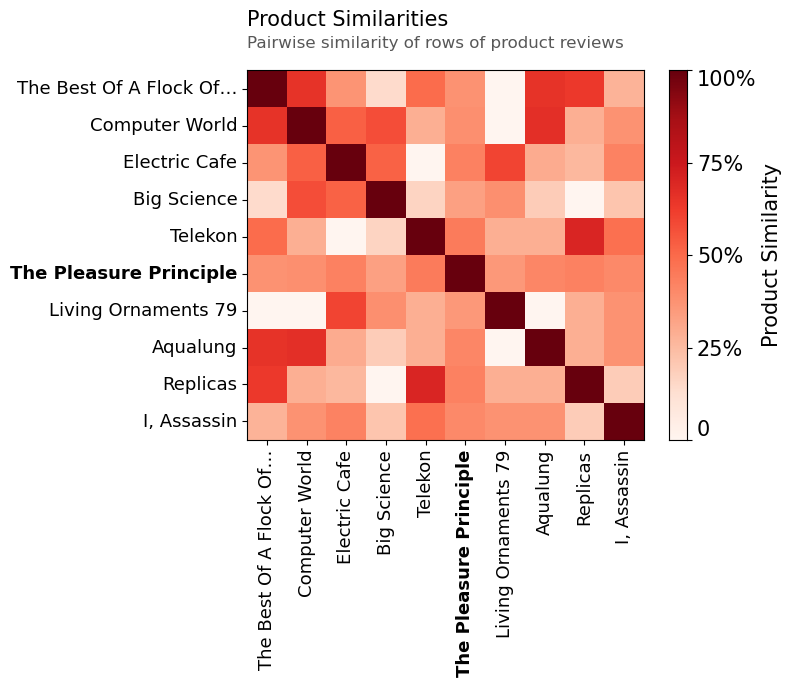

In [14]:
pairwise_similarities = pairwise_cosine_similarities.map(lambda x: 1 - x)
viz.plot_pairwise_similarities(pairwise_similarities, product.title, conn, product_name_limit = product_name_limit)   
plt.gcf().savefig('../images/recommendation-similarities.png', bbox_inches = 'tight')

Let's put the above two together into a shared plot so we can see the connection:

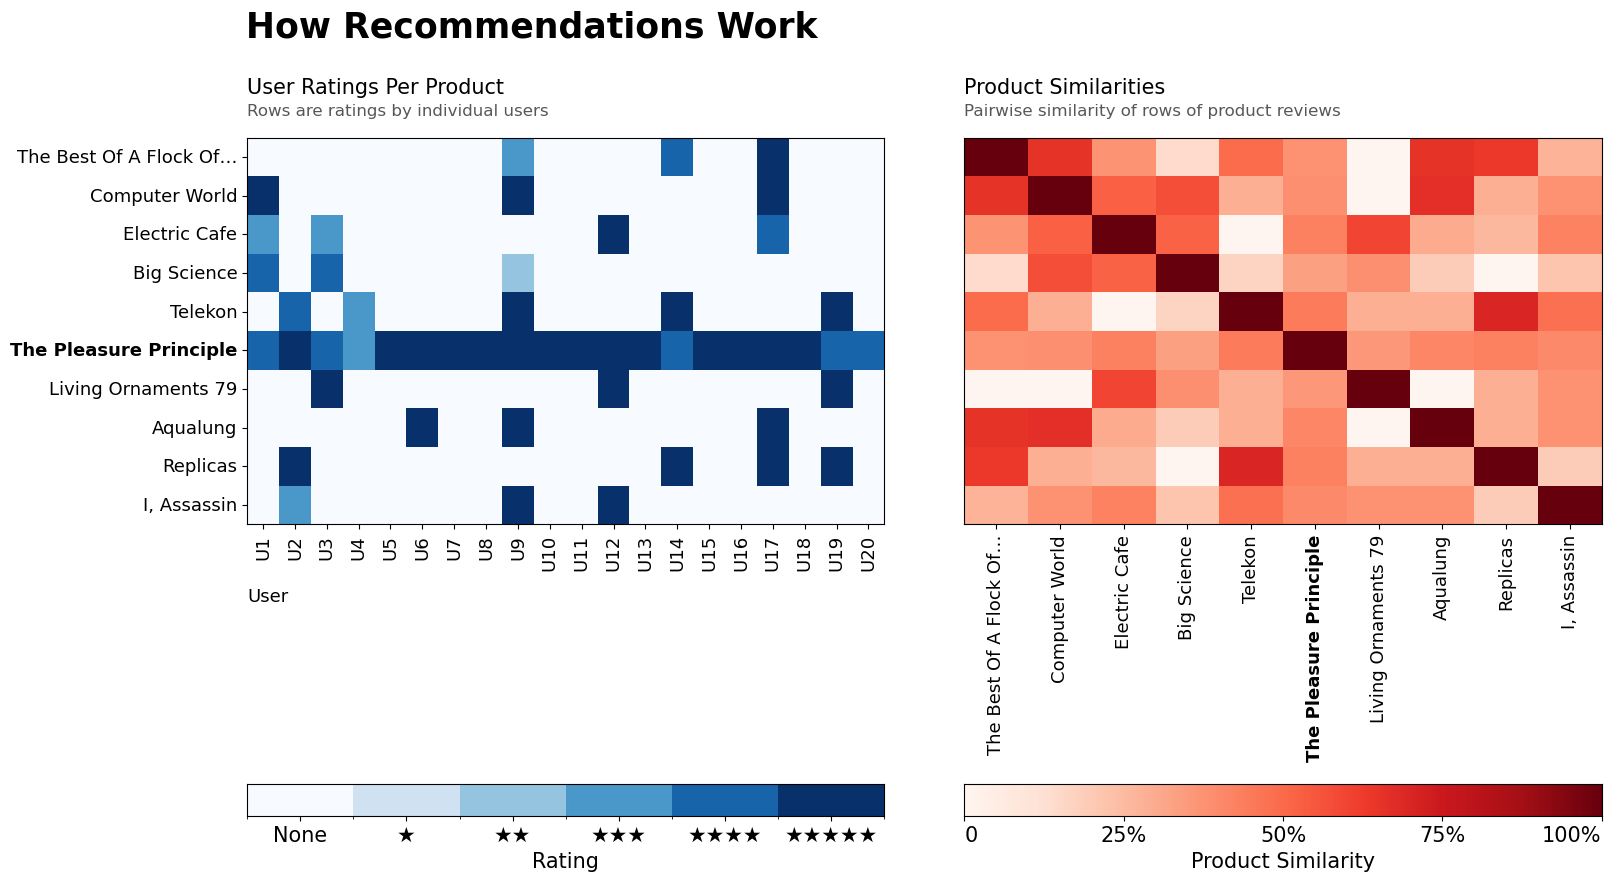

In [26]:

layout = 'constrained'
fig = plt.figure(figsize = (16,8), layout = layout)
fig.set_constrained_layout_pads(wspace = 0.1)
ax_ratings = plt.subplot(121)
viz.plot_user_ratings_by_product(user_ratings_per_product, product.title, conn, product_name_limit = product_name_limit, cbar_kws={'orientation': 'horizontal'})
ax_similarities = plt.subplot(122)
ax_similarities.yaxis.set_visible(False)
viz.plot_pairwise_similarities(pairwise_similarities, product.title, conn, product_name_limit = product_name_limit, cbar_kws = {'orientation': 'horizontal'})

colorbar_ratings = ax_ratings.collections[0].colorbar

fig.suptitle('How Recommendations Work', fontsize = 25, fontweight = 'bold', y = 1.08, x = 0.15, horizontalalignment = 'left')
#fig.set_facecolor(('k', 0.05))

similarity_color_bar = ax_similarities.collections[0].colorbar
similarity_ticklabels = similarity_color_bar.ax.xaxis.get_ticklabels()
similarity_ticklabels[0].set_horizontalalignment('left')
similarity_ticklabels[-1].set_horizontalalignment('right')

fig.savefig('../images/recommendations.png', bbox_inches = 'tight', transparent = False)

In [ ]:
recommendations = pairwise_cosine_similarities.loc[product.id]
results = q.get_recommendations_from_reviews(product.id, related_reviews, conn)
results